In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import time
from loguru import logger
from src.aknn.aknn_cluster  import plot_clustering_distribution, aknn_train, aknn_predict
import numpy as np
from datetime import timedelta
import warnings
from src.aknn import gaussian as gs
import configparser
#warnings.filterwarnings('ignore')
#config = configparser.ConfigParser()
#config.read('src/aknn/config.ini')

In [2]:
CONFIG = {
    "target_index": 0,
    "rolling": 4,
    "entropy_delta": 0.12,
}

## Step 1: load energy consumption data

In [3]:
ele_df = pd.read_csv('public data/Bldg59_clean data/ele.csv', usecols=['date','mels_S','lig_S','mels_N','hvac_N','hvac_S'])
ele_df['hvac'] = ele_df['hvac_N'] + ele_df['hvac_S']
ele_df['date'] = pd.to_datetime(ele_df['date'])
ele_df.rename(columns={'date':'datetime'}, inplace=True)
ele_df['date'] = ele_df['datetime'].dt.date
ele_df['hour'] = ele_df['datetime'].dt.hour

ele_df = ele_df.groupby(['date', 'hour']).agg({'mels_S':'mean', 
                                                 'lig_S':'mean', 
                                                 'mels_N':'mean', 
                                                 'hvac_N':'mean',
                                                 'hvac_S':'mean',
                                                 'hvac': 'mean'}).reset_index()

def trans_date_and_hour_to_time(x):
    return pd.to_datetime(x['date']) + pd.Timedelta(hours=x['hour'])

## only ['datetime', 'hvac'] is needed
ele_df['datetime'] = ele_df[['date', 'hour']].apply(lambda x: trans_date_and_hour_to_time(x), axis=1)
ele_df = ele_df[['datetime', 'hvac']]

In [4]:
### load weather data
weather_df = pd.read_csv('public data/Bldg59_clean data/site_weather.csv')
weather_df.rename(columns={'date':'datetime'}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df['date'] = weather_df['datetime'].dt.date
weather_df['hour'] = weather_df['datetime'].dt.hour
weather_df = weather_df.groupby(['date','hour']).agg({'air_temp_set_1':'mean',
                                                      'air_temp_set_2':'mean',
                                                      'dew_point_temperature_set_1d':'mean',
                                                      'relative_humidity_set_1':'mean',
                                                      'solar_radiation_set_1':'mean'}).reset_index()
weather_df['air_temp'] = weather_df['air_temp_set_1'] + weather_df['air_temp_set_2']
## only ['datetime', 'air_temp', 'relative_humidity_set_1', 'solar_radiation_set_1', 'dew_point_temperature_set_1d'] is needed
weather_df['datetime'] = weather_df[['date', 'hour']].apply(lambda x: trans_date_and_hour_to_time(x), axis=1)
weather_df = weather_df[['datetime', 'air_temp', 'relative_humidity_set_1', 'solar_radiation_set_1', 'dew_point_temperature_set_1d']]

In [5]:
### load HVAC system data (no enough hvac data)
hvac_df = pd.read_csv('public data/Bldg59_clean data/ashp_cw.csv')
hvac_df['date'] = pd.to_datetime(hvac_df['date'])
hvac_df.rename(columns={'date':'datetime'}, inplace=True)
hvac_df['date'] = hvac_df['datetime'].dt.date
hvac_df['hour'] = hvac_df['datetime'].dt.hour

hvac_df = hvac_df.groupby(['date', 'hour']).agg({'aru_001_cwr_temp':'mean', 
                                                 'aru_001_cws_fr_gpm':'mean', 
                                                 'aru_001_cws_temp':'mean'}).reset_index()

hvac_df['delta_temp'] = hvac_df['aru_001_cwr_temp'] - hvac_df['aru_001_cws_temp']
## only ['datetime', 'aru_001_cwr_temp', 'aru_001_cws_fr_gpm', 'aru_001_cws_temp', 'delta_temp'] is needed
hvac_df['datetime'] = hvac_df[['date', 'hour']].apply(lambda x: trans_date_and_hour_to_time(x), axis=1)
hvac_df = hvac_df[['datetime', 'aru_001_cwr_temp', 'aru_001_cws_fr_gpm', 'aru_001_cws_temp', 'delta_temp']]
hvac_df.shape

(3665, 5)

The HVAC data is too limited, only energy consumption data and weather data is used for demo. The cooling data in {6, 7, 8, 9, 10} is used for analysis

In [6]:
#### merge ele_df, weather_df, hvac_df together
summary_data = pd.merge(weather_df, ele_df, how='outer', on='datetime')
summary_data.index = summary_data['datetime']
summary_data.interpolate(method='linear', limit_direction='both', inplace=True)

summary_data['date'] = summary_data['datetime'].dt.date
summary_data['year'] = summary_data['datetime'].dt.year
summary_data['dayofweek'] = summary_data['datetime'].dt.weekday
summary_data['hourofday'] = summary_data['datetime'].dt.hour

summary_test_data = summary_data[summary_data['date'] >= datetime.date(2019, 7, 1)]
summary_test_data = summary_test_data[summary_test_data['date'] <= datetime.date(2019, 12, 1)]
summary_train_data = summary_data[summary_data['date'] < datetime.date(2020, 7, 1)]

summary_test_data = summary_test_data[summary_test_data['datetime'].dt.month.isin([6,7,8,9,10])]
summary_train_data = summary_train_data[summary_train_data['datetime'].dt.month.isin([6,7,8,9,10])]

In [7]:
summary_train_data.columns

Index(['datetime', 'air_temp', 'relative_humidity_set_1',
       'solar_radiation_set_1', 'dew_point_temperature_set_1d', 'hvac', 'date',
       'year', 'dayofweek', 'hourofday'],
      dtype='object')

<AxesSubplot:xlabel='datetime'>

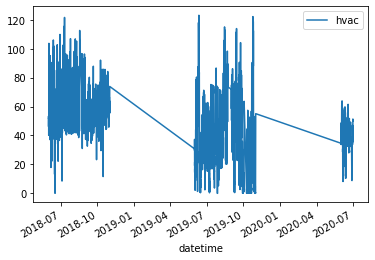

In [8]:
summary_train_data.plot(x='datetime', y='hvac')

Text(0.5, 1.0, 'The prediction in the first 28 days')

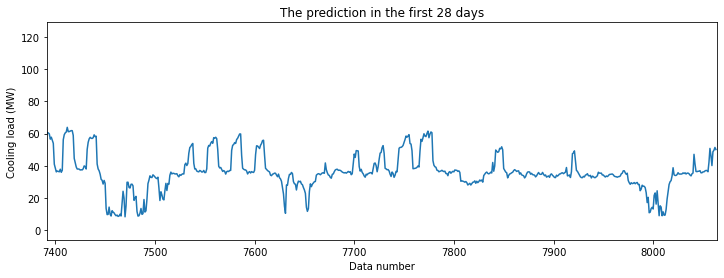

In [9]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
summary_train_data.reset_index(drop=True)['hvac'].plot(ax=ax)
ax.set(xlim=[summary_train_data.shape[0] - 24*28, summary_train_data.shape[0]], xlabel='Data number', ylabel='Cooling load (MW)')
ax.set_title('The prediction in the first 28 days')

Text(0.5, 1.0, 'The prediction in the first 28 days')

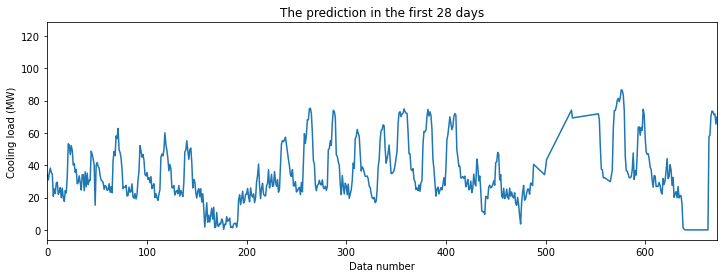

In [10]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
summary_test_data.reset_index(drop=True)['hvac'].plot(ax=ax)
ax.set(xlim=[0, 24*28], xlabel='Data number', ylabel='Cooling load (MW)')
ax.set_title('The prediction in the first 28 days')

In [11]:
summary_test_data.head()

,datetime,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,hvac,date,year,dayofweek,hourofday
datetime,,,,,,,,,,
2019-07-01 00:00:00,2019-07-01 00:00:00,34.8850,55.8600,554.3000,10.3625,34.100071,2019-07-01,2019,0,0
2019-07-01 01:00:00,2019-07-01 01:00:00,33.8300,57.7150,372.9000,10.2025,30.898862,2019-07-01,2019,0,1
2019-07-01 02:00:00,2019-07-01 02:00:00,32.2800,60.9675,190.0250,10.1275,35.306293,2019-07-01,2019,0,2
2019-07-01 03:00:00,2019-07-01 03:00:00,29.1225,69.9450,35.9475,10.0475,38.267875,2019-07-01,2019,0,3
2019-07-01 04:00:00,2019-07-01 04:00:00,26.2825,78.7200,0.1400,9.9350,35.271825,2019-07-01,2019,0,4


In [12]:
summary_test_data.shape

(2952, 10)

## Step 2： AKNN kernels


C:\Users\HAIZHO\OneDrive - DNV\01-Personnal\02-yun\code\formal\src\aknn\aknn_cluster.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.dropna(inplace=True)


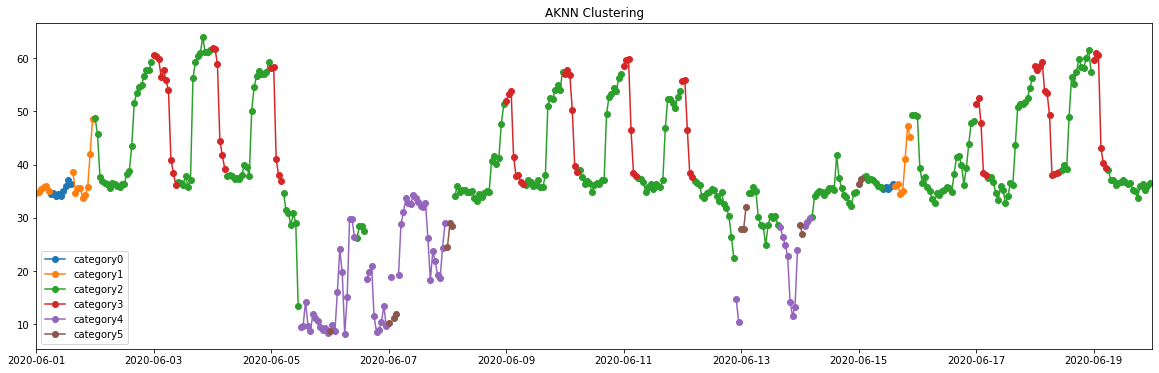

In [13]:
 '''
Plot clustering data results distribution

:param dataframe: Data need to plotted
:param start_time_clustering: Start time of data
:param end_time_clustering: End time of data
:param col_target: The index of target column
:param rolling: Length of historical data to look back
:param entropy_delta: Constraining the number of kernels parameter entropy_delta.
:return: Displaying the distribution graph of data clustering results
'''
    
start_time_plot = "2020-06-01"
end_time_plot = "2020-06-20"
target_index = CONFIG['target_index']
rolling = CONFIG['rolling']
entropy_delta = CONFIG['entropy_delta']

plot_clustering_distribution(summary_train_data, start_time_plot, end_time_plot, target_index, rolling, entropy_delta)

In [15]:
## get learned kernels based on some training samples
tmp_df = summary_train_data[(summary_train_data["datetime"] >= pd.to_datetime(start_time_plot)) & (
        summary_train_data["datetime"] < pd.to_datetime(end_time_plot))]
tmp_df.dropna(inplace=True)
tmp_df.reset_index(drop=True, inplace=True)

_, aknn_clustering_model = aknn_train(tmp_df, target_index, rolling, entropy_delta)

<ipython-input-15-04aa3744592d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df.dropna(inplace=True)
C:\Users\HAIZHO\OneDrive - DNV\01-Personnal\02-yun\code\formal\src\aknn\aknn_cluster.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering[f"kernel_{i}"] = np.nan
C:\Users\HAIZHO\Anaconda3\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Extract features run: 0.7157430648803711


In [16]:
summary_train_data_cluster = aknn_predict(summary_train_data, aknn_clustering_model, target_index)

C:\Users\HAIZHO\OneDrive - DNV\01-Personnal\02-yun\code\formal\src\aknn\aknn_cluster.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering[f"kernel_{i}"] = np.nan
C:\Users\HAIZHO\Anaconda3\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


Extract features run: 16.831714391708374


In [18]:
summary_train_data_cluster.head()

,datetime,hvac,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,dayofweek,hourofday,kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5
0,2018-06-01 00:00:00,52.0200,30.9775,54.9725,523.5250,6.8225,4,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-01 01:00:00,53.4200,30.2250,56.5750,340.5000,6.8150,4,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-01 02:00:00,46.1500,28.6225,59.8725,159.7250,6.7675,4,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-01 03:00:00,48.4225,25.6075,68.2775,21.1750,7.1100,4,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-01 04:00:00,45.5000,23.0425,72.4475,0.1525,6.6850,4,4,2.708823e-66,3.959091e-79,0.999466,0.000002,0.000266,0.000266


In [19]:
summary_test_data_cluster = aknn_predict(summary_test_data, aknn_clustering_model, target_index)
summary_test_data_cluster.head()

C:\Users\HAIZHO\OneDrive - DNV\01-Personnal\02-yun\code\formal\src\aknn\aknn_cluster.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering[f"kernel_{i}"] = np.nan
C:\Users\HAIZHO\Anaconda3\lib\site-packages\pandas\core\indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


Extract features run: 4.783752202987671


,datetime,hvac,air_temp,relative_humidity_set_1,solar_radiation_set_1,dew_point_temperature_set_1d,dayofweek,hourofday,kernel_0,kernel_1,kernel_2,kernel_3,kernel_4,kernel_5
0,2019-07-01 00:00:00,34.100071,34.8850,55.8600,554.3000,10.3625,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01 01:00:00,30.898862,33.8300,57.7150,372.9000,10.2025,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01 02:00:00,35.306293,32.2800,60.9675,190.0250,10.1275,0,2,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-01 03:00:00,38.267875,29.1225,69.9450,35.9475,10.0475,0,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-01 04:00:00,35.271825,26.2825,78.7200,0.1400,9.9350,0,4,6.040098e-16,4.210736e-14,0.994472,2.549270e-09,3.677319e-27,0.005528


In [21]:
summary_train_data_cluster.to_csv("./temp_data/train_data.csv", index=False)
summary_test_data_cluster.to_csv("./temp_data/test_data.csv", index=False)